In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('./Datasets/orders_2.csv')

df.head(5)

,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,payment_value,customer_id,order_purchase_timestamp,customer_unique_id,customer_city
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,2017-09-19 09:45:35,58.9,13.29,cool_stuff,72.19,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,2017-07-05 02:44:11,55.9,17.96,cool_stuff,73.86,e6eecc5a77de221464d1c4eaff0a9b64,2017-06-28 11:52:20,0fb8e3eab2d3e79d92bb3fffbb97f188,jatai
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,2018-05-23 10:56:25,64.9,18.33,cool_stuff,83.23,4ef55bf80f711b372afebcb7c715344a,2018-05-18 10:25:53,3419052c8c6b45daf79c1e426f9e9bcb,belo horizonte
3,6f8c31653edb8c83e1a739408b5ff750,1.0,4244733e06e7ecb4970a6e2683c13e61,2017-08-07 18:55:08,58.9,16.17,cool_stuff,75.07,30407a72ad8b3f4df4d15369126b20c9,2017-08-01 18:38:42,e7c828d22c0682c1565252deefbe334d,sao jose dos pinhais
4,7d19f4ef4d04461989632411b7e588b9,1.0,4244733e06e7ecb4970a6e2683c13e61,2017-08-16 22:05:11,58.9,13.29,cool_stuff,72.19,91a792fef70ecd8cc69d3c7feb3d12da,2017-08-10 21:48:40,0bb98ba72dcc08e95f9d8cc434e9a2cc,conselheiro lafaiete


<h1> EDA and data filtering

In [7]:
# Step 1: Handle missing values
# We will fill missing numerical values with the median and categorical values with the mode.
numerical_cols = ['order_item_id', 'price', 'freight_value', 'payment_value']
categorical_cols = ['product_id', 'shipping_limit_date', 'product_category_name_english']

for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Check if there are any missing values left
missing_values = df.isnull().sum()
missing_values

order_id                         0
order_item_id                    0
product_id                       0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name_english    0
payment_value                    0
customer_id                      0
order_purchase_timestamp         0
customer_unique_id               0
customer_city                    0
dtype: int64

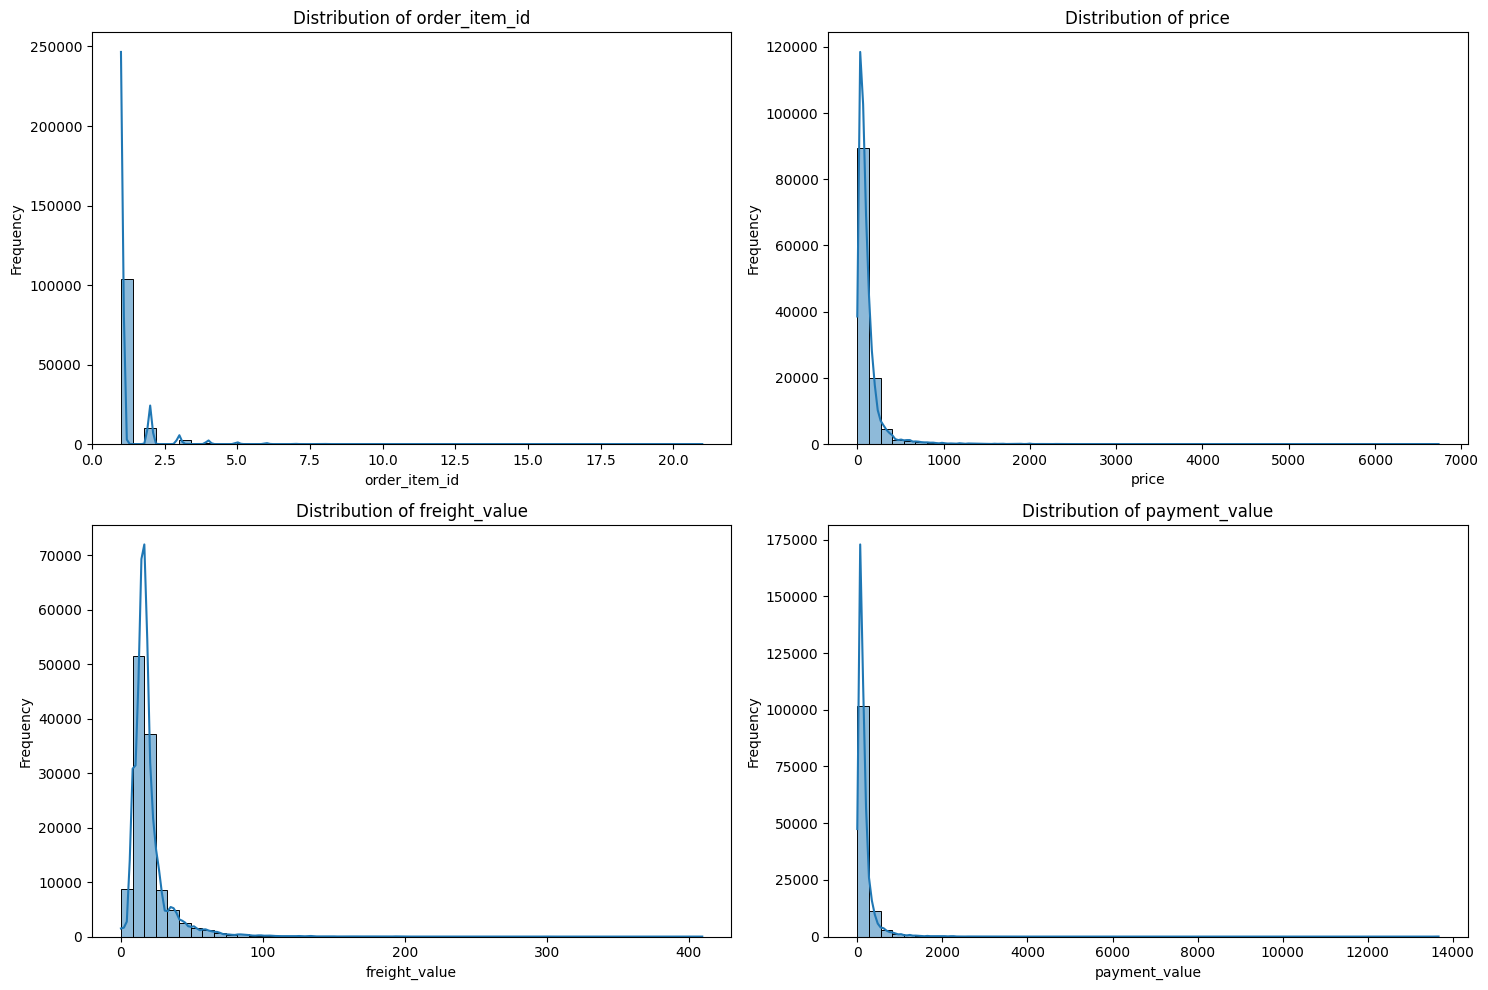

In [8]:
# Step 2: Visualize the distribution of numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

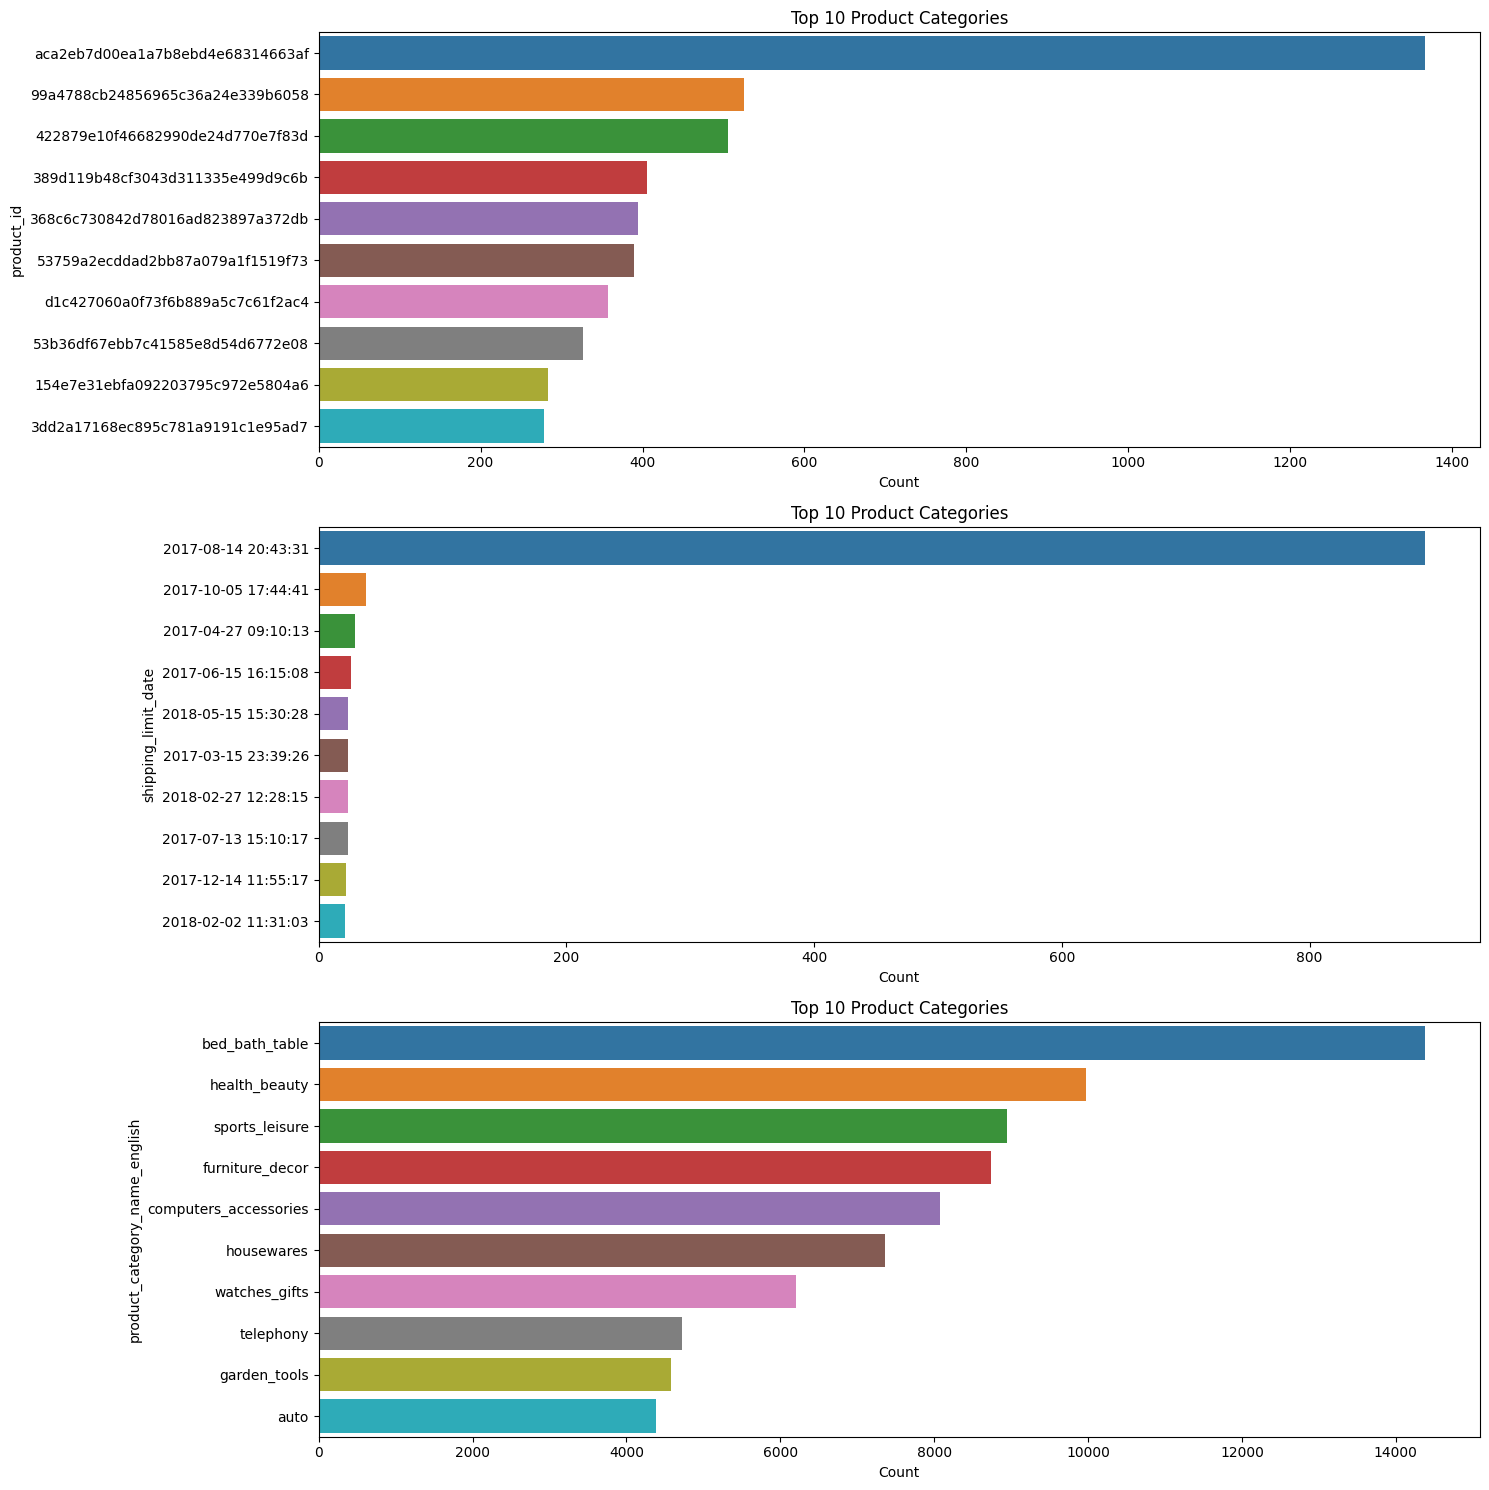

In [9]:
# Step 3: Analyze the categorical columns
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 1, i)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])
    plt.title(f'Top 10 Product Categories')
    plt.xlabel('Count')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

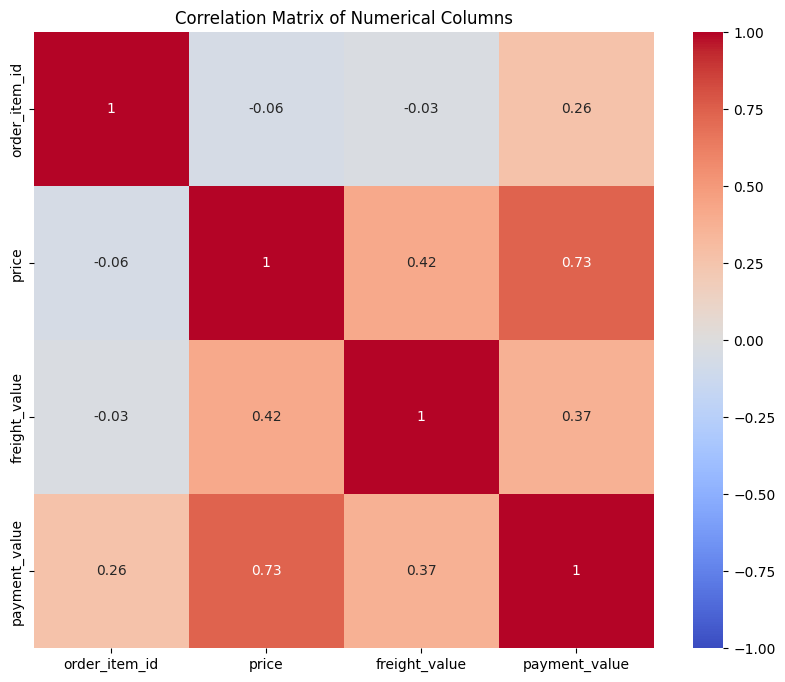

In [10]:
# Step 4: Check for any correlations between columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

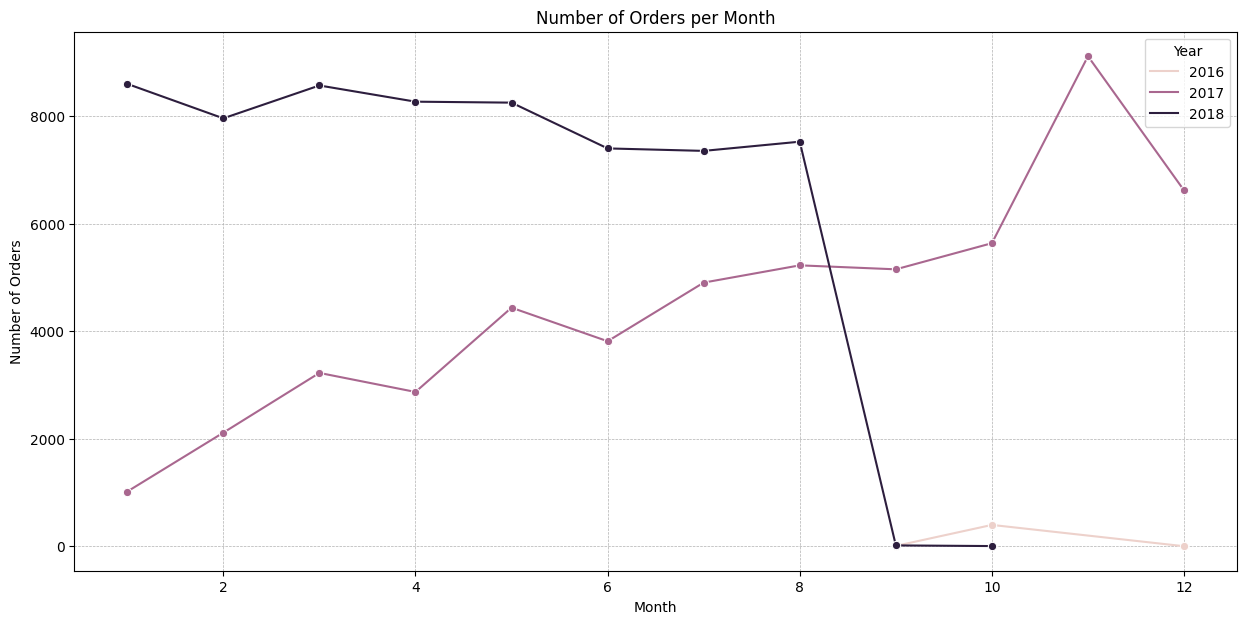

In [11]:
# Step 5: Analyze trends based on the 'order_purchase_timestamp' column
# Convert 'order_purchase_timestamp' to datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Extract month and year from the timestamp
df['purchase_month'] = df['order_purchase_timestamp'].dt.month
df['purchase_year'] = df['order_purchase_timestamp'].dt.year

# Group by month and year to get the number of orders per month
monthly_orders = df.groupby(['purchase_year', 'purchase_month']).size().reset_index(name='number_of_orders')

# Plotting the trend
plt.figure(figsize=(15, 7))
sns.lineplot(x='purchase_month', y='number_of_orders', hue='purchase_year', data=monthly_orders, marker='o')
plt.title('Number of Orders per Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.legend(title='Year')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

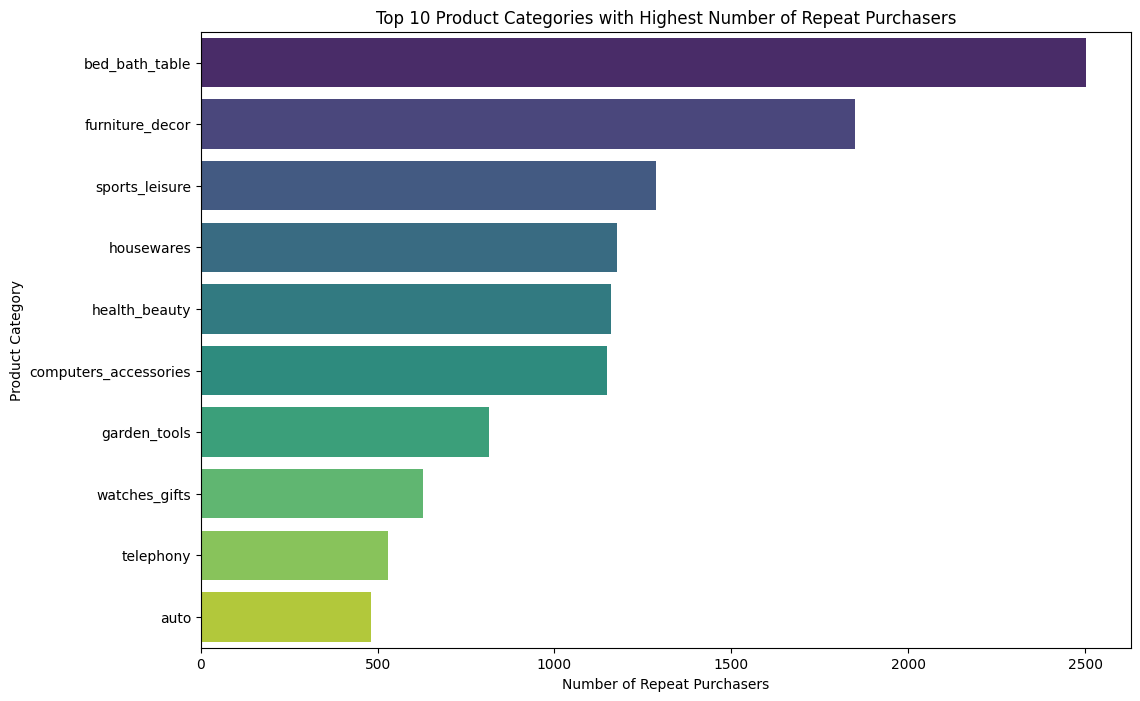

In [12]:
# First, let's identify repeat purchasers
repeat_purchasers = df['customer_unique_id'].value_counts()[df['customer_unique_id'].value_counts() > 1].index

# Filter the dataset for repeat purchasers
repeat_purchasers_df = df[df['customer_unique_id'].isin(repeat_purchasers)]

# Group by product category and count the number of repeat purchasers for each category
category_repeat_purchase = repeat_purchasers_df.groupby('product_category_name_english')['customer_unique_id'].nunique().reset_index()
category_repeat_purchase = category_repeat_purchase.sort_values(by='customer_unique_id', ascending=False)

# Plotting the top 10 product categories with the highest number of repeat purchasers
plt.figure(figsize=(12, 8))
sns.barplot(y='product_category_name_english', x='customer_unique_id', data=category_repeat_purchase.head(10), palette='viridis')
plt.title('Top 10 Product Categories with Highest Number of Repeat Purchasers')
plt.xlabel('Number of Repeat Purchasers')
plt.ylabel('Product Category')
plt.show()

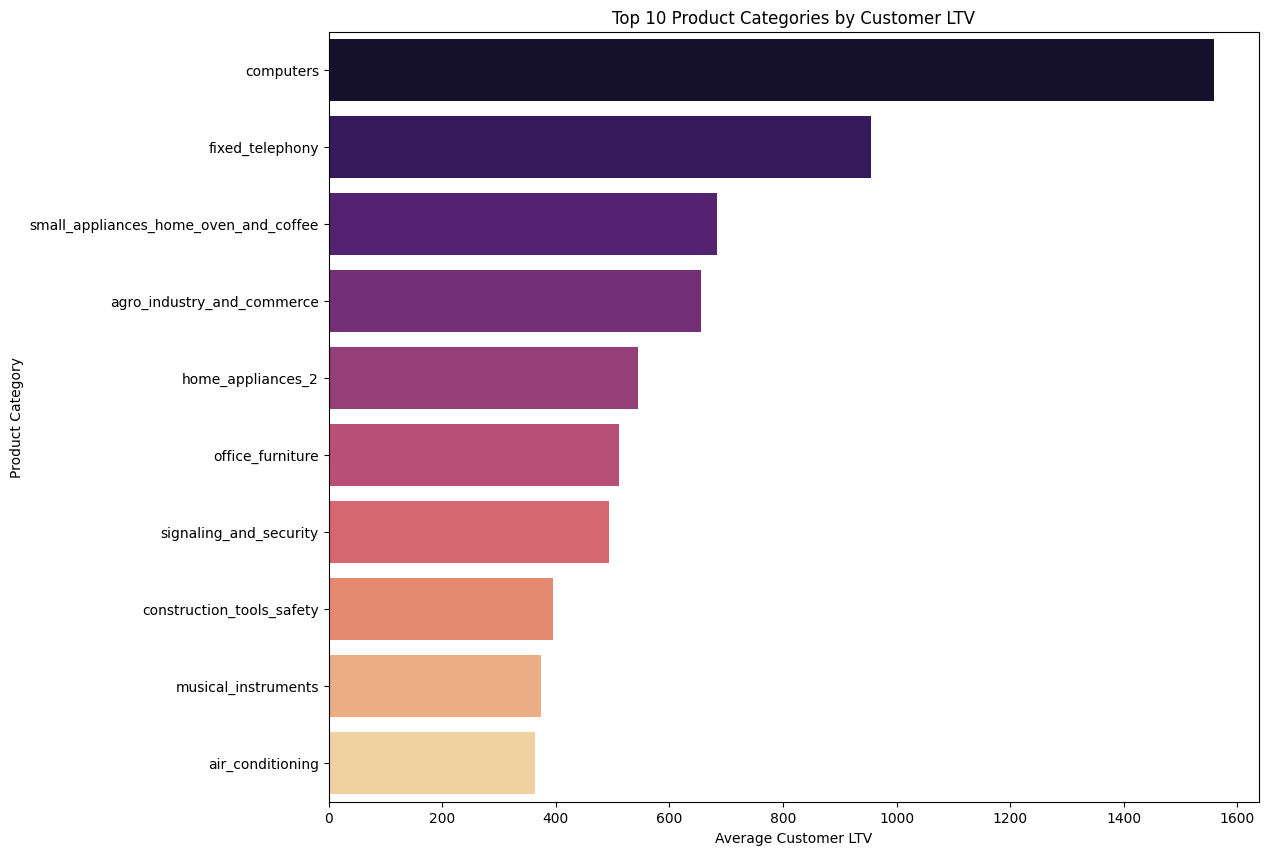

In [13]:
# Customer Lifetime Value (LTV) Analysis by Product

# Calculate the total payment value for each customer and product combination
customer_product_value = df.groupby(['customer_unique_id', 'product_category_name_english'])['payment_value'].sum().reset_index()

# Calculate the average LTV for each product category
product_ltv = customer_product_value.groupby('product_category_name_english')['payment_value'].mean().reset_index()
product_ltv = product_ltv.sort_values(by='payment_value', ascending=False)

# Plotting the LTV for each product category
plt.figure(figsize=(12, 10))
sns.barplot(y='product_category_name_english', x='payment_value', data=product_ltv.head(10), palette='magma')
plt.title('Top 10 Product Categories by Customer LTV')
plt.xlabel('Average Customer LTV')
plt.ylabel('Product Category')
plt.show()

<h1> Customer Analysis Begins

In [14]:
# Customer Analysis

# 1. LTV and Repeat Purchase Rate
# Calculate LTV for each customer
customer_ltv = df.groupby('customer_unique_id')['payment_value'].sum().reset_index()
average_ltv = customer_ltv['payment_value'].mean()

# Calculate Repeat Purchase Rate
total_customers = df['customer_unique_id'].nunique()
repeat_customers = df['customer_unique_id'].value_counts()[df['customer_unique_id'].value_counts() > 1].nunique()
repeat_purchase_rate = repeat_customers / total_customers

average_ltv, repeat_purchase_rate

#make CSV

(213.02709020146517, 0.000280969030969031)

In [15]:
# Analyzing LTV and repeat purchase rate based on the first purchase
# Identify the first purchase for each customer
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
first_purchase = df.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'min'})
first_purchase_df = df.merge(first_purchase, on=['customer_unique_id', 'order_purchase_timestamp'])

# Calculate LTV for each product category based on the first purchase
first_purchase_ltv = first_purchase_df.groupby('product_category_name_english')['payment_value'].mean().reset_index()
first_purchase_ltv = first_purchase_ltv.sort_values(by='payment_value', ascending=False)

# Calculate Repeat Purchase Rate for each product category based on the first purchase
repeat_purchase_by_product = first_purchase_df.groupby('product_category_name_english')['customer_unique_id'].count().reset_index()
repeat_purchase_by_product = repeat_purchase_by_product.sort_values(by='customer_unique_id', ascending=False)

first_purchase_ltv.head(10)

,product_category_name_english,payment_value
14,computers,1282.508037
34,fixed_telephony,775.054436
64,small_appliances_home_oven_and_coffee,656.786154
0,agro_industry_and_commerce,483.880617
45,home_appliances_2,468.991145
57,office_furniture,364.735698
62,signaling_and_security,345.395102
19,construction_tools_safety,334.999896
56,musical_instruments,326.982422
63,small_appliances,319.412743


In [16]:
repeat_purchase_by_product.head(10)

,product_category_name_english,customer_unique_id
7,bed_bath_table,13641
43,health_beauty,9695
65,sports_leisure,8608
39,furniture_decor,8356
15,computers_accessories,7790
49,housewares,7092
70,watches_gifts,6009
68,telephony,4609
42,garden_tools,4452
5,auto,4278


In [17]:
!pip install -q mlxtend

561.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


To do:
1. Do repeat purchasers have a higher LTV than single time customers
2. Next order prediction
3. Churn modelling
4. Predicted LTV

In [18]:
# Group by customer_unique_id and count the number of orders using the dataframe named 'DF'
customer_orders = df.groupby('customer_unique_id').agg(num_orders=('order_id', 'nunique'))

# Identify repeat and one-time purchasers
customer_orders['purchaser_type'] = 'one-time'
customer_orders.loc[customer_orders['num_orders'] > 1, 'purchaser_type'] = 'repeat'

# Display the first few rows of the dataframe
customer_orders

,num_orders,purchaser_type
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,1,one-time
0000b849f77a49e4a4ce2b2a4ca5be3f,1,one-time
0000f46a3911fa3c0805444483337064,1,one-time
0000f6ccb0745a6a4b88665a16c9f078,1,one-time
0004aac84e0df4da2b147fca70cf8255,1,one-time
...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,one-time
fffea47cd6d3cc0a88bd621562a9d061,1,one-time
ffff371b4d645b6ecea244b27531430a,1,one-time


In [19]:
# Group by customer_unique_id and count the number of orders using the dataframe named 'df'
customer_orders = df.groupby('customer_unique_id').agg(num_orders=('order_id', 'nunique'))

# Identify repeat and one-time purchasers
customer_orders['purchaser_type'] = 'one-time'
customer_orders.loc[customer_orders['num_orders'] > 1, 'purchaser_type'] = 'repeat'

# Display the first few rows of the dataframe
customer_orders.head()

,num_orders,purchaser_type
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,1,one-time
0000b849f77a49e4a4ce2b2a4ca5be3f,1,one-time
0000f46a3911fa3c0805444483337064,1,one-time
0000f6ccb0745a6a4b88665a16c9f078,1,one-time
0004aac84e0df4da2b147fca70cf8255,1,one-time


In [20]:
# Merge the main dataframe with the customer_orders dataframe to get the purchaser_type for each customer
merged_df = df.merge(customer_orders[['purchaser_type']], left_on='customer_unique_id', right_index=True)

# Calculate the LTV for each group
ltv_data = merged_df.groupby(['customer_unique_id', 'purchaser_type']).agg(total_purchase_value=('payment_value', 'sum')).reset_index()
ltv_avg = ltv_data.groupby('purchaser_type').agg(avg_LTV=('total_purchase_value', 'mean'))

# Display the average LTV for each group
ltv_avg


,avg_LTV
purchaser_type,
one-time,205.211238
repeat,455.819216


In [21]:
# Convert the 'order_purchase_timestamp' to a datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Extract the month and year from the 'order_purchase_timestamp' to create a 'month_year' column
df['month_year'] = df['order_purchase_timestamp'].dt.to_period('M')

# Merge the main dataframe with the customer_orders dataframe to get the purchaser_type for each customer
merged_df = df.merge(customer_orders[['purchaser_type']], left_on='customer_unique_id', right_index=True)

# Calculate the LTV for each group and time period
ltv_data = merged_df.groupby(['month_year', 'customer_unique_id', 'purchaser_type']).agg(total_purchase_value=('price', 'sum')).reset_index()
ltv_avg = ltv_data.groupby(['month_year', 'purchaser_type']).agg(avg_LTV=('total_purchase_value', 'mean'))

# Display the average LTV for each group and time period
ltv_avg


avg_LTV
month_year purchaser_type            
2016-09    one-time         85.565000
2016-10    one-time        163.175696
           repeat          143.278333
2016-12    repeat           10.900000
2017-01    one-time        169.522040
           repeat          167.020847
2017-02    one-time        151.422323
           repeat          135.010263
2017-03    one-time        148.465116
           repeat          202.523971
2017-04    one-time        162.920294
           repeat          212.811563
2017-05    one-time        150.050421
           repeat          169.450749
2017-06    one-time        142.311676
           repeat          155.405981
2017-07    one-time        134.393161
           repeat          167.074477
2017-08    one-time        140.691174
           repeat          171.597143
2017-09    one-time        156.787581
           repeat          177.493824
2017-10    one-time        153.137056
           repeat          153.972261
2017-11    one-time        140.429515
           repeat          167.720499
2017-12    one-time        136.663025
           repeat          169.359407
2018-01    one-time        136.380006
           repeat          174.672730
2018-02    one-time        132.384656
           repeat          168.328260
2018-03    one-time        144.142120
           repeat          150.585247
2018-04    one-time        148.808738
           repeat          167.706974
2018-05    one-time        150.902382
           repeat          170.198502
2018-06    one-time        148.359484
           repeat          150.652529
2018-07    one-time        147.399680
           repeat          179.720798
2018-08    one-time        137.030738
           repeat          153.417542
2018-09    one-time         74.900000
           repeat           99.333333
2018-10    one-time         74.900000
           repeat           74.900000

In [ ]:
# Convert DataFrame to CSV
ltv_avg.to_csv('ltv_time.csv', index=False)

In [28]:
# Filter the merged dataframe to get only repeat purchasers
repeat_purchasers = merged_df[merged_df['purchaser_type'] == 'repeat']

# Sort the dataframe by customer_unique_id and order_purchase_timestamp to get the first order for each customer
repeat_purchasers_sorted = repeat_purchasers.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# Drop duplicate customer_unique_id to keep only the first order for each customer
first_orders = repeat_purchasers_sorted.drop_duplicates(subset='customer_unique_id', keep='first')

# Group by product_category_name_english to get the count of products bought on the first order
products_first_order = first_orders.groupby('product_category_name_english').size().reset_index(name='count')
products_first_order_sorted = products_first_order.sort_values(by='count', ascending=False)

# Display the products bought by repeat purchasers on their first order
products_first_order_sorted

,product_category_name_english,count
7,bed_bath_table,483
58,sports_leisure,290
35,furniture_decor,276
39,health_beauty,246
14,computers_accessories,194
...,...,...
23,dvds_blu_ray,1
57,small_appliances_home_oven_and_coffee,1
9,books_imported,1
29,fashion_sport,1


In [33]:
# Group by product_category_name_english and product_id to get the count of each product sold
product_popularity = df.groupby(['product_category_name_english', 'product_id']).size().reset_index(name='count')

# Sort the products in each category by their popularity
product_popularity_sorted = product_popularity.sort_values(by=['product_category_name_english', 'count'], ascending=[True, False])

# For each category, get the top 5 most popular products
top_products_per_category = product_popularity_sorted.groupby('product_category_name_english').head(5)

# Display the top products for each category
top_products_per_category

,product_category_name_english,product_id,count
7,agro_industry_and_commerce,11250b0d4b709fee92441c5f34122aed,44
24,agro_industry_and_commerce,423a6644f0aa529e8828ff1f91003690,19
35,agro_industry_and_commerce,672e757f331900b9deea127a2a7b79fd,17
2,agro_industry_and_commerce,07f01b6fcacc1b187a71e5074199db2d,15
40,agro_industry_and_commerce,a0fe1efb855f3e786f0650268cd77f44,15
...,...,...,...
32072,watches_gifts,53b36df67ebb7c41585e8d54d6772e08,327
32496,watches_gifts,a62e25e09e05e6faf31d90c6ec1aa3d1,228
32810,watches_gifts,e0d64dcfaa3b6db5c54ca298ae101d05,201
32519,watches_gifts,a92930c327948861c015c919a0bcb4a8,164


In [34]:
# Select a random customer's first order
random_customer_first_order = df.sort_values(by='order_purchase_timestamp').drop_duplicates(subset='customer_unique_id', keep='first').sample(1)
customer_id = random_customer_first_order['customer_unique_id'].values[0]

# Get the product categories from the customer's first order
purchased_categories = random_customer_first_order['product_category_name_english'].tolist()

# Recommend the top products from those categories
recommended_products = top_products_per_category[top_products_per_category['product_category_name_english'].isin(purchased_categories)]

# Display the recommended products for the customer
recommended_products

,product_category_name_english,product_id,count
11131,electronics,7ce94ab189134e2d3c05f496d635419c,107
11175,electronics,93c902b021a9e594f658ab1b0351602a,73
11224,electronics,ab1f9387c0627dd24000bfbc54fdeee0,70
11267,electronics,bdc3291ab242ec1effc8eb0987850268,69
11067,electronics,5d66715cc928aadd0074f61332698593,68


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Data Preparation
# Create a column to indicate repeat purchaser
df['is_repeat'] = df['customer_unique_id'].isin(customer_orders[customer_orders['purchaser_type'] == 'repeat'].index).astype(int)

# Feature Engineering
# Number of unique categories purchased by the customer
unique_categories = df.groupby('customer_unique_id')['product_category_name_english'].nunique().reset_index()
unique_categories.columns = ['customer_unique_id', 'num_unique_categories']

# Total number of purchases by the customer
total_purchases = df.groupby('customer_unique_id').size().reset_index(name='total_purchases')

# Merge the features into a single dataframe
features = df[['customer_unique_id', 'is_repeat']].drop_duplicates()
features = features.merge(unique_categories, on='customer_unique_id', how='left')
features = features.merge(total_purchases, on='customer_unique_id', how='left')

# Split the data into training and test sets
X = features[['num_unique_categories', 'total_purchases']]
y = features['is_repeat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep

(0.9801248699271592,
 '              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99     18593\n           1       0.75      0.58      0.66       627\n\n    accuracy                           0.98     19220\n   macro avg       0.87      0.79      0.82     19220\nweighted avg       0.98      0.98      0.98     19220\n')

In [36]:
# Extract feature importances from the model
feature_importances = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# Get the top 10 product categories leading to repeat purchasing
top_categories = df[df['is_repeat'] == 1]['product_category_name_english'].value_counts().head(10).index.tolist()

# For each of the top categories, get the most popular products as the predicted next order
predicted_next_order = top_products_per_category[top_products_per_category['product_category_name_english'].isin(top_categories)].groupby('product_category_name_english').head(1)

predicted_next_order

,product_category_name_english,product_id,count
5614,bed_bath_table,aca2eb7d00ea1a7b8ebd4e68314663af,830
8623,computers_accessories,d1c427060a0f73f6b889a5c7c61f2ac4,357
12111,fashion_bags_accessories,d017a2151d543a9885604dc62a3d9dcc,147
14778,furniture_decor,aca2eb7d00ea1a7b8ebd4e68314663af,536
16011,garden_tools,422879e10f46682990de24d770e7f83d,505
16764,health_beauty,154e7e31ebfa092203795c972e5804a6,283
20394,housewares,42a2c92a0979a949ca4ea89ec5c7b934,185
27536,sports_leisure,c6336fa91fbd87c359e44f5dca5a90ed,94
30094,telephony,e7cc48a9daff5436f63d3aad9426f28b,100
32072,watches_gifts,53b36df67ebb7c41585e8d54d6772e08,327


<h1> Churn Prediction

In [37]:
# Convert order_purchase_timestamp to datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Calculate the maximum purchase date for each customer
last_purchase_date = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
last_purchase_date.columns = ['customer_unique_id', 'last_purchase_date']

# Calculate the difference between the last purchase date and the maximum date in the dataset
last_purchase_date['days_since_last_purchase'] = (df['order_purchase_timestamp'].max() - last_purchase_date['last_purchase_date']).dt.days

# Classify customers as churned if they haven't made a purchase in the last 90 days
last_purchase_date['is_churned'] = last_purchase_date['days_since_last_purchase'].apply(lambda x: 1 if x > 90 else 0)

# Display the first few rows of the dataframe
last_purchase_date.head()

,customer_unique_id,last_purchase_date,days_since_last_purchase,is_churned
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,160,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,163,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,585,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,369,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,336,1


In [38]:
# Merge the churn data with the main dataframe to get product categories associated with each customer
df_churn = df.merge(last_purchase_date[['customer_unique_id', 'is_churned']], on='customer_unique_id', how='left')

# Calculate the churn rate for each product category
product_churn_rate = df_churn.groupby('product_category_name_english')['is_churned'].mean().reset_index()
product_churn_rate.columns = ['product_category_name_english', 'churn_rate']

# Sort the product categories by churn rate
product_churn_rate_sorted = product_churn_rate.sort_values(by='churn_rate', ascending=False)

# Get the products with the highest and lowest churn rates
highest_churn_products = product_churn_rate_sorted.head(5)
lowest_churn_products = product_churn_rate_sorted.tail(5)

highest_churn_products, lowest_churn_products

(   product_category_name_english  churn_rate
 67        tablets_printing_image         1.0
 29     fashion_childrens_clothes         1.0
 11             cds_dvds_musicals         1.0
 61         security_and_services         1.0
 52                    la_cuisine         1.0,
             product_category_name_english  churn_rate
 18              construction_tools_lights    0.709265
 36                                   food    0.699620
 64  small_appliances_home_oven_and_coffee    0.666667
 58                         party_supplies    0.630435
 3                   arts_and_craftmanship    0.250000)

In [39]:
highest_churn_products

,product_category_name_english,churn_rate
67,tablets_printing_image,1.0
29,fashion_childrens_clothes,1.0
11,cds_dvds_musicals,1.0
61,security_and_services,1.0
52,la_cuisine,1.0


In [40]:
lowest_churn_products

,product_category_name_english,churn_rate
18,construction_tools_lights,0.709265
36,food,0.699620
64,small_appliances_home_oven_and_coffee,0.666667
58,party_supplies,0.630435
3,arts_and_craftmanship,0.250000


In [41]:
# Feature Engineering for Churn Prediction

# Average time between purchases for each customer
df_churn['order_purchase_timestamp'] = pd.to_datetime(df_churn['order_purchase_timestamp'])
df_churn_sorted = df_churn.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
df_churn_sorted['time_since_last_order'] = df_churn_sorted.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days
avg_time_between_purchases = df_churn_sorted.groupby('customer_unique_id')['time_since_last_order'].mean().reset_index()

# Merge the new feature with the existing features
features_churn = features.merge(avg_time_between_purchases, on='customer_unique_id', how='left')

# Fill NaN values (for customers with only one purchase) with a large value
features_churn['time_since_last_order'].fillna(999, inplace=True)

# Split the data into training and test sets
X_churn = features_churn[['num_unique_categories', 'total_purchases', 'time_since_last_order']]
y_churn = features_churn['is_repeat']
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(X_churn, y_churn, test_size=0.2, random_state=42)

# Model Building for Churn Prediction
clf_churn = RandomForestClassifier(random_state=42)
clf_churn.fit(X_train_churn, y_train_churn)
y_pred_churn = clf_churn.predict(X_test_churn)

# Model Evaluation
accuracy_churn = accuracy_score(y_test_churn, y_pred_churn)
classification_rep_churn = classification_report(y_test_churn, y_pred_churn)

accuracy_churn, classification_rep_churn

(0.9906867845993756,
 '              precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00     18593\n           1       1.00      0.72      0.83       627\n\n    accuracy                           0.99     19220\n   macro avg       0.99      0.86      0.91     19220\nweighted avg       0.99      0.99      0.99     19220\n')

In [42]:
# Extract feature importances from the churn model
feature_importances_churn = pd.DataFrame(clf_churn.feature_importances_, index=X_train_churn.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances_churn

,importance
time_since_last_order,0.574786
num_unique_categories,0.320662
total_purchases,0.104551


In [43]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with the model and hyperparameters
grid_search = GridSearchCV(estimator=clf_churn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model to the training data
grid_search.fit(X_train_churn, y_train_churn)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 108 candidates, totalling 540 fits


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
1330.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1330.69s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1330.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1330.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1330.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1330.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1330.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1330.76s - pydevd: Sending me

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [44]:
from sklearn.metrics import classification_report, accuracy_score

# Train the model with the best hyperparameters
optimized_clf_churn = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
optimized_clf_churn.fit(X_train_churn, y_train_churn)

# Predict on the test set
y_pred_churn = optimized_clf_churn.predict(X_test_churn)

# Evaluate the model
accuracy = accuracy_score(y_test_churn, y_pred_churn)
classification_rep = classification_report(y_test_churn, y_pred_churn)

accuracy, classification_rep

(0.9906867845993756,
 '              precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00     18593\n           1       1.00      0.72      0.83       627\n\n    accuracy                           0.99     19220\n   macro avg       0.99      0.86      0.91     19220\nweighted avg       0.99      0.99      0.99     19220\n')

<h1> RFM ANALYSIS

In [46]:
# Load the CSV file
df = pd.read_csv('./datasets/orders_2.csv')

# Convert 'order_purchase_timestamp' column to datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Calculate Recency, Frequency, and Monetary values for each customer

# Recency
recency = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency.columns = ['customer_unique_id', 'last_purchase_date']
recency['recency'] = (df['order_purchase_timestamp'].max() - recency['last_purchase_date']).dt.days

# Frequency
frequency = df.groupby('customer_unique_id')['order_id'].count().reset_index()
frequency.columns = ['customer_unique_id', 'frequency']

# Monetary
monetary = df.groupby('customer_unique_id')['payment_value'].sum().reset_index()
monetary.columns = ['customer_unique_id', 'monetary']

# Merge the dataframes
rfm = recency.merge(frequency, on='customer_unique_id').merge(monetary, on='customer_unique_id')
rfm = rfm[['customer_unique_id', 'recency', 'frequency', 'monetary']]

rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
2,0000f46a3911fa3c0805444483337064,585,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89


In [47]:
# Correcting the Monetary calculation using the 'price' column

# Monetary
monetary = df.groupby('customer_unique_id')['price'].sum().reset_index()
monetary.columns = ['customer_unique_id', 'monetary']

# Merge the dataframes
rfm = recency.merge(frequency, on='customer_unique_id').merge(monetary, on='customer_unique_id')
rfm = rfm[['customer_unique_id', 'recency', 'frequency', 'monetary']]

rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,18.90
2,0000f46a3911fa3c0805444483337064,585,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,336,1,180.00
